# Mid-semester assignment
**Student name**: Suyash Lal <br>
**Student ID**: 210477

### Library imports

In [1]:
import subprocess                   # For system commands/ffplay
import os                           # File operations
from io import BytesIO              # In-memory audio streaming
from pydub import AudioSegment      # Audio processing
from pydub.playback import play     # Playback override
import matplotlib.pyplot as plt     # Visualization
import numpy as np                  # Signal processing
from scipy.signal import find_peaks # Peak detection


## Preprocessing

### Override play() function
This function overrides pydub’s default play() method to stream audio directly from memory instead of creating temporary files. It avoids **Windows permission errors** by using *BytesIO* to store the audio in RAM and pipes it to ffplay for playback. This allows you to use play(wav) seamlessly without temporary files, while maintaining compatibility with pydub’s standard workflow. This makes it possible to work on any machine, regardless of permissions.

In [4]:
def _play_with_ffplay_memory_fix(audio_segment):
    buffer = BytesIO()
    audio_segment.export(buffer, format="wav")
    buffer.seek(0)
    
    ffplay_cmd = [
        "ffplay",
        "-nodisp",      # Disable the GUI
        "-autoexit",    # Close ffplay when playback is done
        "-hide_banner", # Suppress ffplay version info
        "-i", "pipe:0"  # Read audio data from stdin
    ]
    
    proc = subprocess.Popen(
        ffplay_cmd,
        stdin=subprocess.PIPE,
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    proc.communicate(input=buffer.read())
    buffer.close()

# Replace pydub's internal ffplay handler with our fixed version
import pydub.playback
pydub.playback._play_with_ffplay = _play_with_ffplay_memory_fix

#### Load the path of the file

In [ ]:
folder_path = "Audio_Files"

# List files in folder_path
files = os.listdir(folder_path)

# Filter only WAV files
wav_files = [f for f in files if f.lower().endswith('.wav')]

if not wav_files:
    print("No WAV files found in the folder.")
else:
    # Display the list of WAV files with numbers
    print("Available WAV files:")
    for i, file in enumerate(wav_files, start=1):
        print(f"{i}. {file}")

    # Select a file
    try:
        selection = int(input("Enter the number of the file you want to process: "))
        if 1 <= selection <= len(wav_files):
            selected_file = wav_files[selection - 1]
            print("-" * 35)
            print(f"You have selected: {selected_file}")

            # Load selected file
            path = os.path.join(folder_path, selected_file)
            file = AudioSegment.from_file(path, format="wav")

        else:
            print("Invalid selection. Please choose a number from the list.")
    except ValueError:
        print("Invalid input. Please enter a number.")

Available WAV files:
1. A_5thString.wav
2. B_2ndString.wav
3. B_7thString.wav
4. E_8thString.wav
5. F_6thString.wav
6. G_6thString.wav
-----------------------------------
You have selected: B_2ndString.wav


Play the audio to test if it can work 

In [6]:
play(file)

#### Data Exploration

In [7]:
# check frame rate
print(file.frame_rate)

# check max amplitude
print(file.max)

# To know about channels of file (1 = mono, 2 = stereo)
print(file.channels)

44100
580195585
2


Convert stereo audio to mono (easier to process and analyze for machine learning, pitch detection, and feature extraction)

In [8]:
file = file.set_channels(1)
print(file.channels)

1


View the audio file graphically 

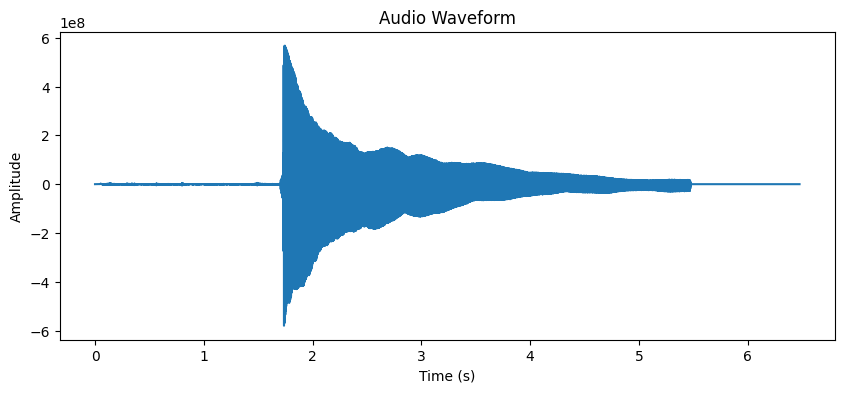

In [9]:
# Convert to numpy array
samples = np.array(file.get_array_of_samples())
sample_rate = file.frame_rate

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, len(samples) / sample_rate, num=len(samples)), samples)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

## Onset Detection
Filter out low frequencies to reduce noise, isolating the peak amplitude 

In [ ]:
file = file.high_pass_filter(82) # value needs to be adjusted per instrument

Spectral Flux calculation (identify sudden changes in the signal)

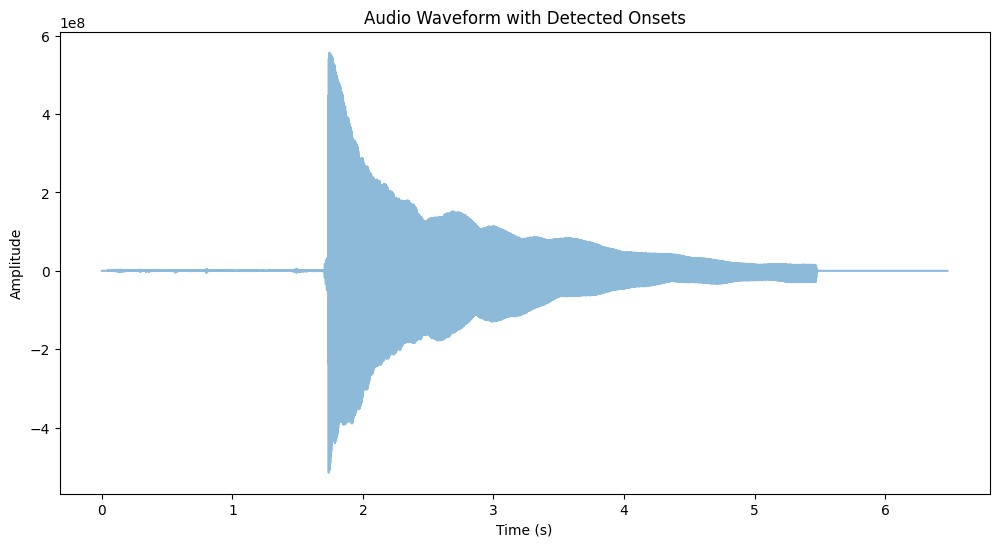

In [11]:
# Onset Detection using Spectral Flux
def compute_spectral_flux(samples, sample_rate, frame_size=1024, hop_size=512):
    # Split audio into frames
    num_frames = int((len(samples) - frame_size) / hop_size) + 1
    frames = np.array([samples[i*hop_size : i*hop_size + frame_size] 
                      for i in range(num_frames)])
    
    # Apply Hann window to reduce spectral leakage
    window = np.hanning(frame_size)
    windowed_frames = frames * window
    
    # Compute FFT magnitudes (ignore phase)
    fft_mags = np.abs(np.fft.rfft(windowed_frames, axis=1))
    
    # Calculate spectral flux
    flux = np.sum(np.diff(fft_mags, axis=0)**2, axis=1)
    flux = np.concatenate([np.zeros(1), flux])  # Pad to match frame count
    
    # Normalize flux
    flux = (flux - np.min(flux)) / (np.max(flux) - np.min(flux))
    
    return flux, num_frames

# Detect onsets using peak picking
def detect_onsets(flux, sample_rate, hop_size=512, threshold=0.2, distance=10):
    peaks, _ = find_peaks(flux, height=threshold, distance=distance)
    onset_times = peaks * hop_size / sample_rate
    return onset_times

# --- MAIN ONSET DETECTION ---
# Convert audio to numpy array
samples = np.array(file.get_array_of_samples())
sample_rate = file.frame_rate

# Compute spectral flux
flux, num_frames = compute_spectral_flux(samples, sample_rate)

# Detect onsets (adjust threshold/distance as needed)
onset_times = detect_onsets(flux, sample_rate, threshold=0.3, distance=15)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, len(samples)/sample_rate, len(samples)), samples, alpha=0.5)
plt.vlines(onset_times, -2**15, 2**15, colors='r', linestyles='dashed')
plt.title("Audio Waveform with Detected Onsets")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

## Audio Segmentation

In [12]:
def segment_peak_audio(audio_segment, onset_times, peak_duration=0.1):
    """
    Segment audio file focusing only on the peak/attack portion of each note
    """
    notes = []
    samples = np.array(audio_segment.get_array_of_samples())
    
    for onset in onset_times:
        # Convert time to samples
        start_idx = int(onset * audio_segment.frame_rate)
        end_idx = start_idx + int(peak_duration * audio_segment.frame_rate)
        
        # Ensure we don't exceed audio length
        end_idx = min(end_idx, len(samples))
        
        if start_idx < end_idx:
            # Get the peak section
            peak_samples = samples[start_idx:end_idx]
            
            # Create AudioSegment from peak section
            peak_audio = AudioSegment(
                peak_samples.tobytes(),
                frame_rate=audio_segment.frame_rate,
                sample_width=audio_segment.sample_width,
                channels=1
            )
            
            notes.append(peak_audio)
    
    return notes

# Execute segmentation
peak_notes = segment_peak_audio(file, onset_times)

#### Export audio to new file

In [13]:
# Create output directory
output_dir = "processed_files"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Export each peak note
for idx, note in enumerate(peak_notes):
    output_file = os.path.join(output_dir, f"peak_note_{idx+1}.wav")
    note.export(output_file, format="wav")
    print(f"Peak note {idx+1} saved to {output_file}")

Peak note 1 saved to processed_files\peak_note_1.wav


#### Visualize the segmented notes

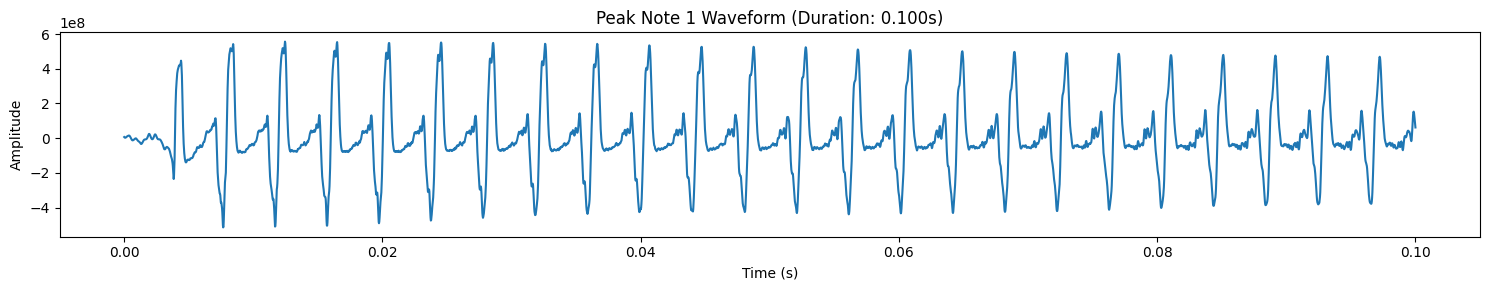

In [14]:
# Visualize each peak note
plt.figure(figsize=(15, 3 * len(peak_notes)))
for idx, note in enumerate(peak_notes):
    # Convert note to numpy array for plotting
    note_samples = np.array(note.get_array_of_samples())
    time_axis = np.linspace(0, len(note_samples) / note.frame_rate, num=len(note_samples))
    
    plt.subplot(len(peak_notes), 1, idx + 1)
    plt.plot(time_axis, note_samples)
    plt.title(f"Peak Note {idx + 1} Waveform (Duration: {len(note)/1000:.3f}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

## Frequency analysis
Fast Fourier Transform (FFT) usage

In [15]:
def analyze_guitar_frequency(note, min_freq=80, max_freq=1200):
    """
    Analyze frequency content of a guitar note with focus on fundamental frequency
    """
    samples = np.array(note.get_array_of_samples())
    sample_rate = note.frame_rate
    
    # Use a longer window for better low-frequency resolution
    n_samples = len(samples)
    n_padded = 2**int(np.ceil(np.log2(n_samples))) * 4
    
    # Apply Hanning window
    window = np.hanning(n_samples)
    windowed_samples = samples * window
    
    # Compute FFT with zero-padding
    fft = np.fft.fft(windowed_samples, n_padded)
    frequencies = np.fft.fftfreq(n_padded, 1/sample_rate)
    
    # Get positive frequencies only
    positive_mask = frequencies > 0
    frequencies = frequencies[positive_mask]
    magnitude_spectrum = np.abs(fft)[positive_mask]
    
    # Limit to relevant frequency range for guitar
    mask = (frequencies >= min_freq) & (frequencies <= max_freq)
    frequencies = frequencies[mask]
    magnitude_spectrum = magnitude_spectrum[mask]
    
    # Find peaks in the spectrum
    peaks, _ = find_peaks(magnitude_spectrum, height=max(magnitude_spectrum)*0.1)
    peak_frequencies = frequencies[peaks]
    peak_magnitudes = magnitude_spectrum[peaks]
    
    # Sort peaks by magnitude
    sort_idx = np.argsort(peak_magnitudes)[::-1]
    peak_frequencies = peak_frequencies[sort_idx]
    peak_magnitudes = peak_magnitudes[sort_idx]
    
    # Find fundamental frequency
    significant_peaks = peak_magnitudes > max(peak_magnitudes) * 0.1
    candidate_freqs = peak_frequencies[significant_peaks]
    fundamental_freq = min(candidate_freqs) if len(candidate_freqs) > 0 else 0
    
    return fundamental_freq, frequencies, magnitude_spectrum, peak_frequencies, peak_magnitudes

#### Visualize the graphs


Note 1 fundamental frequency: 247.6 Hz
Strongest frequency components:
Frequency: 495.3 Hz, Relative magnitude: 1.000
Frequency: 742.9 Hz, Relative magnitude: 0.889
Frequency: 990.5 Hz, Relative magnitude: 0.470
Frequency: 247.6 Hz, Relative magnitude: 0.407


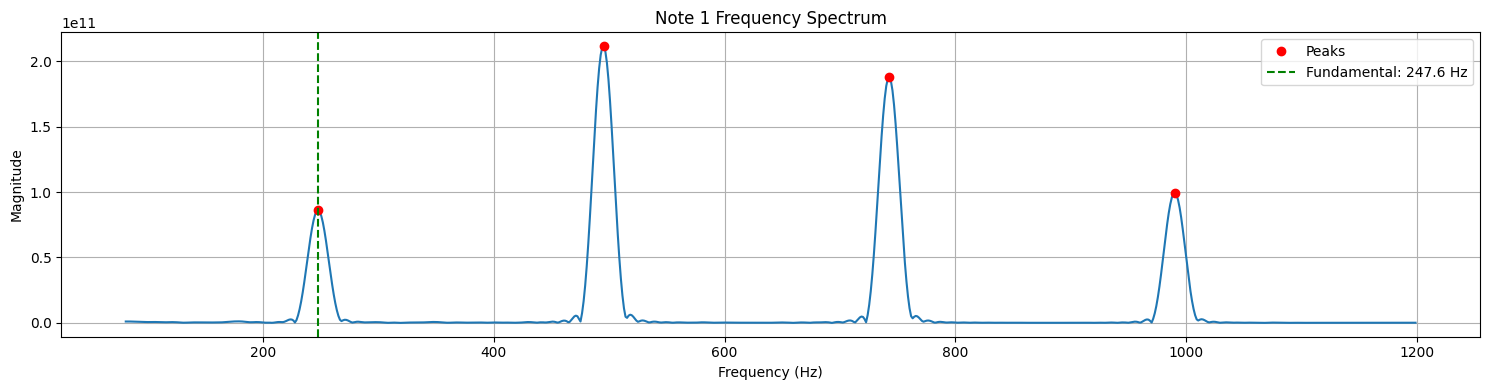

In [16]:
# Analyze and visualize frequency content for all notes
if peak_notes:
    plt.figure(figsize=(15, 4 * len(peak_notes)))
    
    for idx, note in enumerate(peak_notes):
        fund_freq, freqs, mags, peak_freqs, peak_mags = analyze_guitar_frequency(note)
        
        # Create subplot for each note
        plt.subplot(len(peak_notes), 1, idx + 1)
        plt.plot(freqs, mags)
        plt.plot(peak_freqs, peak_mags, 'ro', label='Peaks')
        plt.axvline(fund_freq, color='g', linestyle='--', 
                   label=f'Fundamental: {fund_freq:.1f} Hz')
        plt.title(f"Note {idx + 1} Frequency Spectrum")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid(True)
        plt.legend()
        
        # Print detected frequencies for each note
        print(f"\nNote {idx + 1} fundamental frequency: {fund_freq:.1f} Hz")
        print("Strongest frequency components:")
        for freq, mag in zip(peak_freqs[:5], peak_mags[:5]):
            print(f"Frequency: {freq:.1f} Hz, Relative magnitude: {mag/max(peak_mags):.3f}")
    
    plt.tight_layout()
    plt.show()

## Note Mapping and Detection

In [17]:
# Mapping function for frequency to note name (aligned with provided chart)
def frequency_to_note(frequency):
    # Reference frequencies for standard tuning based on provided table
    note_frequencies = {
        "C" : [130.8, 261.6, 523.3, 1047],
        "C#": [138.6, 277.2, 554.4, 1109],
        "D" : [146.8, 293.7, 587.3, 1175],
        "D#": [155.6, 311.1, 622.3],
        "E" : [82.41, 164.8, 329.6, 659.3],
        "F" : [87.31, 174.6, 349.2, 698.5],
        "F#": [92.50, 185.0, 370.0, 740.0],
        "G" : [98.00, 196.0, 392.0, 784.0],
        "G#": [103.8, 207.7, 415.3, 830.6],
        "A" : [110.0, 220.0, 440.0, 880.0],
        "A#": [116.5, 233.1, 466.2, 932.3],
        "B" : [123.5, 246.9, 493.9, 987.8]
    }
    
    # Find the closest note
    closest_note = None
    min_difference = float("inf")
    
    for note, freqs in note_frequencies.items():
        for ref_freq in freqs:
            difference = abs(ref_freq - frequency)
            if difference < min_difference:
                min_difference = difference
                closest_note = note

    return closest_note
 
note = frequency_to_note(fund_freq)
print(f"Detected Note: {note}")


Detected Note: B
